### Working with Regression Models

In [1]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.datasets import make_classification
import seaborn as sns #I found this which was great for making a heat map!
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math 

In [2]:
# Load the automobile dataset
df = pd.read_csv('auto-mpg.csv')
df.head() 

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# To make the variables easier to work with later, will rename columns with spaces between words
df = df.rename(columns={'model year': 'model_year', 'car name': 'car_name'})

In [4]:
# Data preparation
# Removing the 'car name' column to avoid modeling issues
# Also attempted dummying the variable but there are too many makes/models to 
# be useful in modeling. Dropping the 'car_name' variable

#pd.get_dummies(df['car_name'])

df.drop('car_name', axis=1, inplace=True)

In [5]:
# The horsepower column values may have imported as string data type. 
# First, confirming what the data types are for the df
# Confirmed horspower is 'object' type, shown as string type
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model_year        int64
origin            int64
dtype: object

In [6]:
# Checking unique values in the 'horsepower' column helps recognize which values
# needing removal or replacement
print(df['horsepower'].unique())

['130' '165' '150' '140' '198' '220' '215' '225' '190' '170' '160' '95'
 '97' '85' '88' '46' '87' '90' '113' '200' '210' '193' '?' '100' '105'
 '175' '153' '180' '110' '72' '86' '70' '76' '65' '69' '60' '80' '54'
 '208' '155' '112' '92' '145' '137' '158' '167' '94' '107' '230' '49' '75'
 '91' '122' '67' '83' '78' '52' '61' '93' '148' '129' '96' '71' '98' '115'
 '53' '81' '79' '120' '152' '102' '108' '68' '58' '149' '89' '63' '48'
 '66' '139' '103' '125' '133' '138' '135' '142' '77' '62' '132' '84' '64'
 '74' '116' '82']


In [7]:
# Unique value search shows '?' as a non-numeric value in the 'horsepower' column
# To address this, I replace the '?' values with column mean
df['horsepower'] = df['horsepower'].replace('?', 
    np.mean(pd.to_numeric (df['horsepower'], errors='coerce')))

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


In [8]:
pd.get_dummies(df['origin'])

,1,2,3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
393,1,0,0
394,0,1,0
395,1,0,0
396,1,0,0


In [9]:
# Creating a correlation coefficient matrix and visualization. 
# Checking for correlation
df.corr()

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
mpg,1.000000,-0.775396,-0.804203,-0.831741,0.420289,0.579267,0.563450
cylinders,-0.775396,1.000000,0.950721,0.896017,-0.505419,-0.348746,-0.562543
displacement,-0.804203,0.950721,1.000000,0.932824,-0.543684,-0.370164,-0.609409
weight,-0.831741,0.896017,0.932824,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.505419,-0.543684,-0.417457,1.000000,0.288137,0.205873
model_year,0.579267,-0.348746,-0.370164,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.562543,-0.609409,-0.581024,0.205873,0.180662,1.000000


<AxesSubplot:>

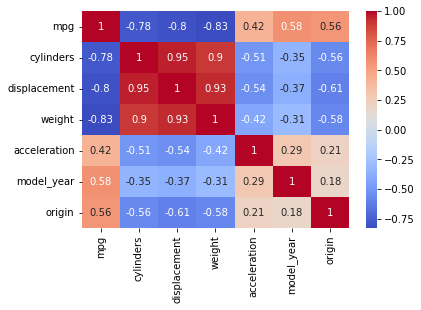

In [10]:
# Visualizing the data with a heatmap using Seaborn
# Early observations show negative correlations between MPG and cylinders, displacement and weight
# While not extremely strong, it also appears model year and vehicle origin are correlated
# Cylinders, weight and displacement are highly correlated with each other
sns.heatmap(df.corr(), annot=True, fmt='.2g', cmap='coolwarm')

In [11]:
# Statistical information about our data
display(df.describe())

,mpg,cylinders,displacement,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


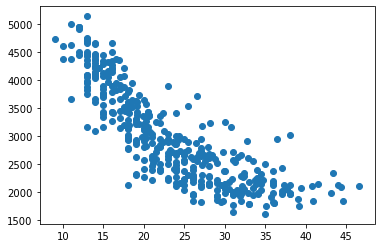

In [12]:
# Plotting 'MPG' vs 'weight'. The Scatter Plot shows that higher weight vehicles will 
# usually have worse fuel economy as measured by MPG
plt.scatter(df.mpg, df.weight)
plt.show()

array([[<AxesSubplot:title={'center':'mpg'}>]], dtype=object)

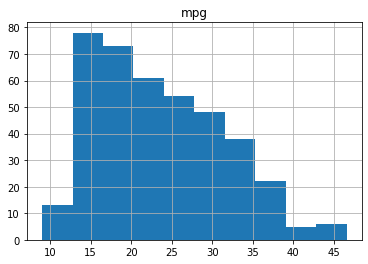

In [13]:
# 'Mpg' for different vehicles shows a strong right skew with most vehicles
# having 'mpg' on the lower end
df.hist(column='mpg')

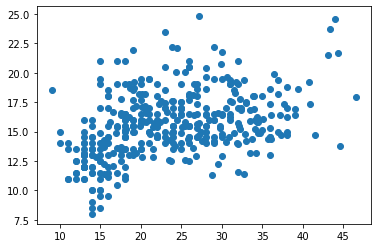

In [14]:
# Plotting 'MPG' vs 'acceleration'. The Scatter Plot shows that acceleration and MPG 
# appear to have some correlation at lower values, becoming increasingly more random
plt.scatter(df.mpg, df.acceleration)
plt.show()

array([[<AxesSubplot:title={'center':'acceleration'}>]], dtype=object)

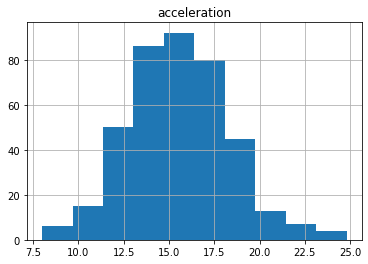

In [15]:
# 'Acceleration' for different vehicles has pretty even distribution with most car
# being centered around 15.0
df.hist(column='acceleration')

#### Linear Regression Model

In [16]:
# Randomly split the data into 80% training data and 20% test data with MPG as the target variable
y = df.mpg  
X = df.drop('mpg', axis=1)

In [17]:
# Setting up the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("\nX_train:\n")
print(X_train.head())
print(X_train.shape)

print("\nX_test:\n")
print(X_test.head())
print(X_test.shape)


X_train:

     cylinders  displacement horsepower  weight  acceleration  model_year  \
358          4         120.0         74    2635          18.3          81   
109          4         140.0         72    2401          19.5          73   
285          8         305.0        130    3840          15.4          79   
304          4          91.0         69    2130          14.7          79   
157          8         350.0        145    4440          14.0          75   

     origin  
358       3  
109       1  
285       1  
304       2  
157       1  
(318, 7)

X_test:

     cylinders  displacement horsepower  weight  acceleration  model_year  \
352          4          98.0         65    2380          20.7          81   
167          4          97.0         75    2171          16.0          75   
194          6         232.0         90    3085          17.6          76   
302          4         105.0         70    2150          14.9          79   
299          4         141.0         7

In [18]:
# Confirming training data is as expected
X_train

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
358,4,120.0,74,2635,18.3,81,3
109,4,140.0,72,2401,19.5,73,1
285,8,305.0,130,3840,15.4,79,1
304,4,91.0,69,2130,14.7,79,2
157,8,350.0,145,4440,14.0,75,1
...,...,...,...,...,...,...,...
348,4,89.0,62,2050,17.3,81,3
395,4,135.0,84,2295,11.6,82,1
35,6,250.0,100,3329,15.5,71,1
176,6,232.0,90,3211,17.0,75,1


In [19]:
# MPG information (the target variable) split between training and testing sets
y_train
y_test

352    29.9
167    29.0
194    22.5
302    34.5
299    27.2
       ... 
11     14.0
363    22.4
301    34.2
297    25.4
130    26.0
Name: mpg, Length: 80, dtype: float64

In [20]:
# Training an ordinary linear regression model on the data
regression = LinearRegression()

In [21]:
#Fitting the linear regression...
model = regression.fit(X_train, y_train)

In [22]:
# Model intercept - the mean value of the response variable at point where all predictors equal 0
model.intercept_

-17.60066805150858

In [23]:
# Coefficient - amount the mean of the dependent variable changes with a shift of 1 unit in a particular 
# independent variable with others at a constant value
model.coef_

array([-0.42739741,  0.02374845, -0.01484606, -0.00709358,  0.12894686,
        0.75177453,  1.52504624])

In [25]:
linear_pred = model.predict(X_test)

In [27]:
# Calculate R2, RMSE, and MAE on both the training and test sets 
# The results appear to show test and training scores are close in predictive ability.
# For ex. the R-Squared score at 84% indicates predictive ability but still
# not completely accurate

print('Train Score: {}\n'.format (model.score(X_train, y_train)))
# score the model on the test set
print('Test Score: {}\n'.format (model.score(X_test, y_test)))
# calculate the overall accuracy of the model
print('R^2/Overall Model Accuracy: {}\n'.format (r2_score (y_test, linear_pred)))
# compute the mean squared error of the model
print('Mean Squared Error: {}\n'.format (mean_squared_error (y_test, linear_pred)))
# compute rmse
print('Root Mean Squared Error: {}'.format(math.sqrt(mean_squared_error(y_test, linear_pred))))

Train Score: 0.8146803801852872

Test Score: 0.8453267958919951

R^2/Overall Model Accuracy: 0.8453267958919951

Mean Squared Error: 8.40640913157608

Root Mean Squared Error: 2.8993808186535412


#### Lasso Regression Model

In [28]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
print ("Lasso model:", (lasso.coef_))

Lasso model: [-0.041207    0.01521436 -0.01179066 -0.00714846  0.09793831  0.74335215
  1.21784996]


In [29]:
# The Lasso model gives similar results to the Linear Regression model, with the
# R-Squared score also roughly 84% - Both models here have similar predictive reliability
pred_train_lasso = lasso.predict(X_train)
print(np.sqrt(mean_squared_error(y_train, pred_train_lasso)))
print(r2_score(y_train, pred_train_lasso))

pred_test_lasso = lasso.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

3.414051147660587
0.8134904791701147
2.886408564943213
0.8467077607070966
